In [17]:
from helpers import *
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


</div>
<div class="1.1 explanation" style='background-color:#08135c; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:white">
       <h3>0. Get the data</h3>
    </span>
</div>
</div>

In [18]:
# get the data
articles, categories, links, paths_finished, paths_unfinished, paths_all, shortest_path_distance = load_data()

# #remove the paths that has only a starting point and are not of our interest
# paths_unfinished = paths_unfinished[paths_unfinished.pathLength > 1]

# Create the graphs of interest
G_paths, G_links = get_graphs(paths_all,links)
G_paths_finished, _ = get_graphs(paths_finished,links)
G_paths_unfinished, _ = get_graphs(paths_unfinished,links)

In [19]:
# Get the number of finished and unfinished node_visited 
nb_finished_node_visited = paths_finished.pathLength.sum()
nb_unfinished_node_visited = paths_unfinished.pathLength.sum()
print("There are %d node that were visited in finished path and %d in unfinished paths"%(nb_finished_node_visited, nb_unfinished_node_visited))

There are 346767 node that were visited in finished path and 124081 in unfinished paths


In [20]:
# Get all the stats from the graphs and the categories we need for the analysis
categories_all = get_all_features_of_categories(categories, G_paths_finished, G_paths_unfinished, nb_finished_node_visited, nb_unfinished_node_visited)
categories_all[['weighted_diff_mean_in_out', 'weighted_diff_finished', 'weighted_diff_unfinished']].head(5)

,weighted_diff_mean_in_out,weighted_diff_finished,weighted_diff_unfinished
splitted_cat,,,
Actors_models_and_celebrities,-0.089356,-0.276753,-0.370563
African_Countries,0.093909,0.043150,0.130787
African_Geography,0.118403,0.013205,0.123787
Air_and_Sea_transport,-0.036228,-0.020322,-0.111400
Ancient_History_Classical_History_and_Mythology,-0.011662,0.001311,0.008437


</div>
<div class="1.1 explanation" style='background-color:#08135c; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:white">
       <h3>1. Introduction</h3>        
    </span>
</div>
</div>
<div class="1.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        <h4>General</h4>
        After having made an analysis based on players history, we now focus on the analysis per game and try to understand what make player finish or not. We first focus on the categories to see if players get stuck in certain ones, and if the starting or the target page has an impact on the success of the game. Then we focus on the paths and try to find out the relationship between the path the player took, the distance to the target and the result of the game, as well as the motivation to keep playing.
        <h4>Approach</h4>
        <ul><li> For categories, we examined the in and out degrees and the possibility to be stuck in those categories. Then, we generate a score for each, indicating if this is a good category to begin with or end with.
           <li> For path analysis, we generated a progress score for each path, and validated its effectiveness on both ended runs and hypothetical "ongoing" runs. Then we found a magical number that is the path length 5. We will elaborate on this number and discuss what we can learn from the results.
        </ul>
        <h4>Purposes and uses</h4>
        When we know if a player has high chances of not finishing the game or if it's having difficulty, we can try to help him. <ul><li>With section 2.1 we will tell him when he/she is stuck in a concept and try to give him a hint on which categories he/she should continue. <li>With section 3, we can decide if the player is not performing well during the game and offer hints when necessary. <li>With section 4, we can know when is the best time (at which path length) to intervene so that the player keeps his motivation to keep playing. <li>Section 5 is the section to produce features for classification, which purpose is to predict the result of the player's next run.</ul>
    </span>
</div>

</div>
<div class="1.1 explanation" style='background-color:#08135c; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:white">
       <h3>2. Analysis on categories</h3>
    </span>
</div>
</div>

</div>
<div class="1.1 explanation" style='background-color:#08135c; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:white">
       <h3>2.1 Look at the difference between in and out degree in finished and unfinished paths </h3>
    </span>
</div>
</div>
<div class="1.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
         <h4>Motivation</h4> 
       We want to analysis where the player can get stuck during their games. For each wikipedia article in the players graph, we have its in and ou degree and these two values are not always the same. In fact when we constructed  the graph we remove edges that went back to the previous pages visited. For example, suppose a player starts with page A, go to B, but then see that it was not a good idea to go to B and use the back button back to A and then go to C. At the end A has in/out degree of 0/2 whereas B has in/out degree 1/0. Therefore, analysising the difference between the degrees can give us insight on where player get stuck.
       <br> 
        In fact when we compute the difference $\delta = in_{deg}- out_{deg}$ we can have to cases : 
        <ul>
            <li>if $\delta$ is big, it means that we came to this node but then came back to the previous one - the player though the he/she was on the wrong way (Node B in our example)</li>
            <li>if $\delta$ is big in negative, it means that we get back and forth <i>from</i> this node not knowing how to escape - the player think he is at a key node but don't know how to go further (Node A in our exemple).</li>
        </ul>
        <h4>Plots</h4>
        Using this fact we plot the difference of in/out degrees for finished and unfinished paths.
        What, we can see is that the $\delta$ for nodes in finished paths are concentrated around 0, which means the go back button was not used much during these games, whereas for unfinished paths, the histogram is skewed wider.
        <h5>Unfinished paths</h5> 
        Looking more specifically to unfinished paths, we see that we have both cases ($\delta$ is large positively and negatively) and what is interesting is that the 
        <ul>
            <li>the nodes with delta large positively, the nodes players go to and then come back (Node B) are the node used more in finished paths like <code class='python'>Politics, History, Chemistry</code> which means that maybe players that did not finish did not adopt the good strategy and should have continued in the paths using these topics.</li>
            <li>the node with delta large negatively, the node players cannot escape are the ones related to topics like <code class='python'>Literature, Theatre, Architecture</code> which are the node used less in finished than in unfinished. So we might conclude that the players should escape these node as soon as possible and used better concepts like  <code class='python'>Politics</code>.</li>
        </ul>
        However, with this analysis we should be carefull with possible <i>cofounder</i> which could be that the topics of <code class='python'>Literature, Theatre, Architecture</code> are intrinsically harder and this is why people get stuck.
    </span>
</div>

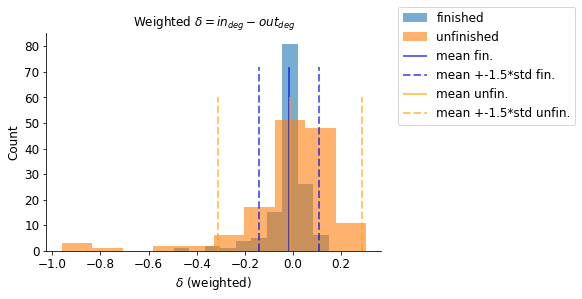

In [22]:
categories_all.weighted_diff_finished.hist(alpha = 0.6, label = 'finished').set_title(r'Weighted $\delta = in_{deg}-out_{deg}$')
categories_all.weighted_diff_unfinished.hist(alpha = 0.6, label = 'unfinished', grid=False)

plt.xlabel(r'$\delta$ (weighted)', size=12)
plt.ylabel('Count', size=12)
mean_fin, std_fin = categories_all.weighted_diff_finished.mean(), categories_all.weighted_diff_finished.std()
mean_unfin, std_unfin = categories_all.weighted_diff_unfinished.mean(), categories_all.weighted_diff_unfinished.std()

val_frac_start = 1.5
y_limit = 60
plt.vlines(mean_fin, 0, y_limit*1.2, ls='-',alpha = 0.6, color='blue', linewidth=2, label = 'mean fin.')
plt.vlines(mean_fin+ val_frac_start *std_fin,  0, y_limit*1.2, ls='--',alpha = 0.6, color='blue', linewidth=2,label ='mean +-'+str(val_frac_start)+'*std fin.')
plt.vlines(mean_fin- val_frac_start * std_fin,  0, y_limit*1.2, ls='--',alpha = 0.6, color='blue', linewidth=2)
plt.vlines(mean_unfin, 0, y_limit, ls='-',alpha = 0.6, color='orange', linewidth=2, label = 'mean unfin.')
plt.vlines(mean_unfin+ val_frac_start *std_unfin,  0, y_limit, ls='--',alpha = 0.6, color='orange', linewidth=2,label ='mean +-'+str(val_frac_start)+'*std unfin.')
plt.vlines(mean_unfin- val_frac_start * std_unfin,  0, y_limit, ls='--',alpha = 0.6, color='orange', linewidth=2)
plt.legend(loc=(1.05, 0.58), prop={'size': 12})
get_first_last(10, categories_all, 'weighted_diff_unfinished')

fig = plt.gcf()
ax = plt.gca()

#ax label formatting
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(12) 

#Remove spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


</div>
<div class="1.1 explanation" style='background-color:#08135c; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:white">
       <h3>2.2 Comparing topics of starting and target pages</h3>
    </span>
</div>
</div>
<div class="1.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        <h4>Plots</h4> 
       We plot two histograms 
        <ul>
            <li>the histogram of the sucess rate of a concept as <b>starting page</b></li>
            <li>the histogram of the sucess rate of a concept as <b>target page</b>.</li>  
        </ul>
        <h4>Starting page</h4> 
        First we see that the starting page histogram has a smaller variance then the target page histogram. This is not a surprise since we know that the starting phase of going to a hub is the easiest part. Moreover we cannot say that a starting page is easier but there are still some pages that seems harder to start with  <code class='python'>['Architecture', 'Theatre', 'Literature_types', 'General_Biology', 'Language_and_literature', 'Design_and_Technology', 'Air_and_Sea_transport', 'Conflict_and_Peace']</code>. In particular, starting with the topic <code class='python'>Architecture</code> lead to a probability of sucess of $0.26$ which means that the game is finished once over 4 attempts.
        <h4>Target page </h4>  
        In the target page histogram, we can see a lot of variance and there are topics that seems to be easier or harder than others. We can see that topics with <code class='python'>Geography</code> or <code class='python'>Countries</code> are quiet easy. Topics as <code class='python'>European_Countries, USA_Presidents, European_Geography</code> are finished more than 4 times over 5 attemps. <br>
        On the other side, topics more related to <code class='python'>Movies</code> or <code class='python'>Literature</code> are harder. For example, the topic <code class='python'>General_Literature</code> has a score of $0.08$ which mean that a game is finished less than 1 times over 10 with this concept as target.
        <h4>Conlusion </h4>  
        Some starting and target concepts has a big impact on the result of a game. We will use these two score for our logistic regression.
    </span>
</div>

In [23]:
# split the categories and and aggregate categories of articles that have multiple categories
categories['categories'] = categories.category.apply(lambda x : x.split('.')[1:])
categories_merged = pd.DataFrame(categories.groupby('article').categories.agg(sum))
start_target_cats = get_start_target_cats(paths_unfinished, paths_finished, categories_merged, nb_finished_node_visited, nb_unfinished_node_visited)
start_target_cats.head(4)

,start_finished,target_finished,start_unfinished,target_unfinished,weighted_diff_start,weighted_diff_target,frac_start,frac_target
start_cats,,,,,,,,
Actors_models_and_celebrities,0.637316,0.259540,0.604444,1.378132,0.026472,-0.683038,0.513236,0.158481
African_Countries,1.626452,2.309908,1.531258,0.628622,0.030147,0.572152,0.515073,0.786076
African_Geography,3.751799,4.565025,3.296234,1.378132,0.064637,0.536229,0.532319,0.768114
Air_and_Sea_transport,0.700759,0.542151,1.023525,0.539970,-0.187189,0.002015,0.406406,0.501008


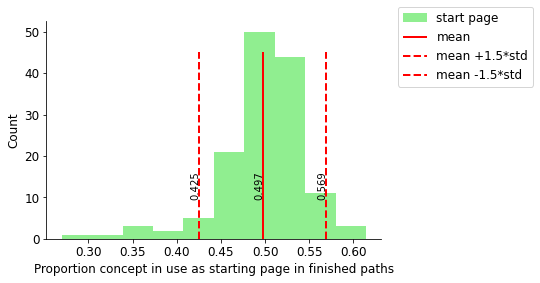

In [24]:
start_target_cats['frac_start'].hist(label = 'start page', grid=False, color = 'lightgreen')
plt.xlabel('Proportion concept in use as starting page in finished paths', size=12)
plt.ylabel('Count', size=12)
mean_frac_start, std_frac_start = start_target_cats['frac_start'].mean(), start_target_cats['frac_start'].std()

val_frac_start = 1.5
y_limit = 45
plt.vlines(mean_frac_start, 0, y_limit, ls='-', color='red', linewidth=2, label = 'mean')
plt.text(mean_frac_start- 0.01,10,'%.3f'%(mean_frac_start),rotation=90)
plt.vlines(mean_frac_start+ val_frac_start *std_frac_start,  0, y_limit, ls='--', color='red', linewidth=2,label ='mean +'+str(val_frac_start)+'*std')
plt.text(mean_frac_start+ val_frac_start *std_frac_start- 0.01,10,\
            '%.3f'%(mean_frac_start+ val_frac_start *std_frac_start),rotation=90)
plt.vlines(mean_frac_start- val_frac_start * std_frac_start,  0, y_limit, ls='--', color='red', linewidth=2, label ='mean -'+str(val_frac_start)+'*std')
plt.text(mean_frac_start- val_frac_start *std_frac_start- 0.01,10,\
            '%.3f'%(mean_frac_start- val_frac_start *std_frac_start),rotation=90)
plt.legend(loc=(1.05, 0.70), prop={'size': 12})

get_first_last(10, start_target_cats, 'frac_start')

fig = plt.gcf()
ax = plt.gca()

#ax label formatting
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(12) 
    
#Remove spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

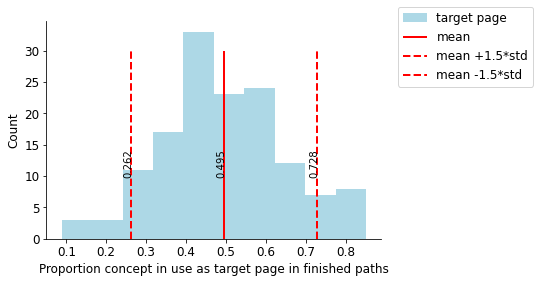

In [25]:
# Look at the target page now
start_target_cats['frac_target'].hist(label = 'target page', grid=False, color = 'lightblue')
plt.xlabel('Proportion concept in use as target page in finished paths', size=12)
plt.ylabel('Count', size=12)
mean_frac_target, std_frac_target = start_target_cats['frac_target'].mean(), start_target_cats['frac_target'].std()

val_frac_target = 1.5
y_limit = 30
plt.vlines(mean_frac_target, 0, y_limit, ls='-', color='red', linewidth=2, label = 'mean')
plt.text(mean_frac_target- 0.02,10,'%.3f'%(mean_frac_target),rotation=90)
plt.vlines(mean_frac_target+ val_frac_target *std_frac_target,  0, y_limit, ls='--', color='red', linewidth=2,label ='mean +'+str(val_frac_target)+'*std')
plt.text(mean_frac_target+ val_frac_target *std_frac_target- 0.02,10,\
            '%.3f'%(mean_frac_target+ val_frac_target *std_frac_target),rotation=90)
plt.vlines(mean_frac_target- val_frac_target * std_frac_target,  0, y_limit, ls='--', color='red', linewidth=2, label ='mean -'+str(val_frac_target)+'*std')
plt.text(mean_frac_target- val_frac_target *std_frac_target- 0.02,10,\
            '%.3f'%(mean_frac_target- val_frac_target *std_frac_target),rotation=90)
plt.legend(loc=(1.05, 0.70), prop={'size': 12})
# Get the easiest and hardest finishing pages
get_first_last(10, start_target_cats, 'frac_target')

fig = plt.gcf()
ax = plt.gca()

#ax label formatting
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(12) 

#Remove spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

</div>
<div class="1.1 explanation" style='background-color:#08135c; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:white">
       <h3>2.3 Plots</h3>
    </span>
</div>
</div>
<div class="1.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        We plot the impact on the starting and the target paths to suceed finishing the game. 
        <br>In <b>red</b> are concepts that have bad impact on finishing a game and in <b>green</b> good impact. This is determined if the score of the starting or target concept is out of 1.5 its standard deviation of its mean.
    </span>
</div>


In [26]:
from bokeh.io import show, output_notebook
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import HoverTool, ResetTool, PanTool, WheelZoomTool, SaveTool, ColorBar, ColorMapper,Range1d
output_notebook()
def get_color_2(x):
    if x.frac_target < mean_frac_target-val_frac_target*std_frac_target \
            or x.frac_start < mean_frac_start-val_frac_start*std_frac_start :
        return 'red'
    elif x.frac_target > mean_frac_target+val_frac_target*std_frac_target \
            or x.frac_start > mean_frac_start+val_frac_start*std_frac_start :
        return 'green'
    else :
        return 'blue'
data = start_target_cats[['frac_start', 'frac_target']].reset_index()
data['color'] = data.apply(lambda x : get_color_2(x), axis = 1)
hover = HoverTool(
    tooltips=[
        ("Name", "@start_cats"),
    ])
tools = [hover, ResetTool(), PanTool(), WheelZoomTool(), SaveTool()]

p = figure(plot_width=660, plot_height=460, tools=tools, title="Comparing sucess of game with start and target topics")
p.title.text_color = "black"
p.title.text_font_size = "15px"
p.xaxis.axis_label = 'Sucess rate with this concept as starting edges'
p.yaxis.axis_label = 'Sucess rate with this concept as target edges'
p.x_range = Range1d(0,1)
p.y_range = Range1d(0,1)

p.circle('frac_start', 'frac_target', color = 'color', source=data, size=15, alpha=0.5)

show(p, notebook_handle=True)

Loading BokehJS ...

</div>
<div class="1.1 explanation" style='background-color:#08135c; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:white">
       <h3>3 Analysis on Path and Distance within a run</h3>
    </span>
</div>

</div>
<div class="1.1 explanation" style='background-color:#08135c; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:white">
       <h3>3.1 Preprocessing DataFrame</h3>
    </span>
</div>
</div>
<div class="1.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        We preprocess the raw inputting dataframe. We first add a column indicating if the round is the corresponding player's last run. In addition, we parsed the path string into a page list, and from our graphs, we calculated the distance to the target for every page the player's been to, in order to help understand how well the player performs. <b>Shortest path length</b>
    </span>
</div>

In [27]:
#Add an extra column indicating if the game is the player's last game
paths_all.index = paths_all['timestamp']
group = paths_all.groupby('hashedIpAddress')
processed_paths_all_raw = pd.DataFrame()
for key, df in group:
    df['bh_type']= 'continue'
    df.loc[df.index.max(),'bh_type'] = 'quit'
    processed_paths_all_raw = pd.concat([processed_paths_all_raw,df])
    
#Because this grouping operation drops out players with null hashedIpAddress,we append them to the last to keep coherence.
null_address = list(set(paths_all['path_id']) - set(processed_paths_all_raw['path_id']))
null_entries = paths_all[paths_all['path_id'].isin(null_address)]
null_entries.insert(1,'bh_type',"continue")
processed_paths_all_raw = pd.concat([processed_paths_all_raw,null_entries])

#Set index to path_id
paths_all.index = paths_all['path_id']

In [28]:
#Parse the path string in df and derive from it the node list, and calculate the distance to target for each node the player has been to 
def _parse_withdraw(path):
    page_stack = []
    parsed_path = []
    time_withdraw = 0
    for node in path:
        if node != '<':
            page_stack.append(node)
        else:
            page_stack.pop()
            time_withdraw = time_withdraw +1
        parsed_path.append(page_stack[-1])
    return [parsed_path, time_withdraw]


processed_paths_all = processed_paths_all_raw[['path_id','hashedIpAddress','path','target','type','bh_type','pathLength']].copy()

#Parse the path string into a list and find the last visited node
processed_paths_all['path'] = processed_paths_all['path'].apply(lambda p: p.split(';'))
processed_paths_all['path'] = processed_paths_all['path'].apply(lambda pl: _parse_withdraw(pl)[0])
processed_paths_all['n_withdraws'] = processed_paths_all['path'].apply(lambda pl: _parse_withdraw(pl)[1])
processed_paths_all['end_node'] = processed_paths_all['path'].apply(lambda p: p[-1])

In [29]:
#Calculating distance to the target for each node visited in the game
def graph_dist(Graph, current_node, target_node):
    try:
        return nx.shortest_path_length(Graph,current_node,target_node)
    except:
        return np.inf

    
processed_paths_all['M_path_dist_to_target'] = processed_paths_all[['path','target']].apply(lambda r: [graph_dist(G_links, r[0][i], r[1]) for i in range(len(r[0]))], axis = 1)
processed_paths_all['P_path_dist_to_target'] = processed_paths_all[['path','target']].apply(lambda r: [graph_dist(G_paths, r[0][i], r[1]) for i in range(len(r[0]))], axis = 1)
processed_paths_all['M_dist_to_target'] = processed_paths_all[['end_node','target']].apply(lambda r: graph_dist(G_links, r[0], r[1]), axis = 1)
processed_paths_all['P_dist_to_target'] = processed_paths_all[['end_node','target']].apply(lambda r: graph_dist(G_paths, r[0], r[1]), axis = 1)

processed_paths_all['Pf_path_dist_to_target'] = processed_paths_all[['path','target']].apply(lambda r: [graph_dist(G_paths_finished, r[0][i], r[1]) for i in range(len(r[0]))], axis = 1)
processed_paths_all['Pu_path_dist_to_target'] = processed_paths_all[['path','target']].apply(lambda r: [graph_dist(G_paths_unfinished, r[0][i], r[1]) for i in range(len(r[0]))], axis = 1)

</div>
<div class="1.1 explanation" style='background-color:#08135c; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:white">
       <h3>3.2 Making dataset for ongoing games</h3>
    </span>
</div>
</div>
<div class="1.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        If we think of each separate move the player makes as a game that is ongoing, we can derive a much richer dataset where we know the final result of the ongoing games.
    </span>
</div>

In [30]:
import random
#Sample number. We only take a portion of original dataframe to generate this dataset
sample_n = 30000
sample_index = [True]*sample_n +[False]*(len(processed_paths_all) - sample_n)
random.shuffle(sample_index)

#Break a finished game into several unfinished games. We know the results.
def break_path(p):
    s = {'path':[], 'finished':[]}
    for i in range(2,len(p)+1):
        s['path'].append(p[:i])
        s['finished'].append(1 if i==len(p) else 0)
    return pd.DataFrame(s)

dataset = pd.DataFrame()
count = 0
for p in list(processed_paths_all[sample_index]['M_path_dist_to_target']):
    dataset = pd.concat([dataset, break_path(p)])
    count = count +1
#    if count % 3000 == 0:
#        print(count)

#Add results to the dataframe
from itertools import chain
dataset['type'] = list(chain(*list(processed_paths_all[['pathLength','type']][sample_index].apply(lambda r: [str(r[1])]*(r[0]-1),axis = 1))))

#Don't miss out the pathLength data
dataset['pathLength'] = dataset['path'].apply(lambda d: len(d))

</div>
<div class="1.1 explanation" style='background-color:#08135c; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:white">
       <h3>3.3 Score player's performance by distance change in the path</h3>
    </span>
</div>
</div>
<div class="1.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        We propose a progress distance score based on the path. It's derived from the path based on the following hypotheses:
        <h4>Our hypotheses for Progress Score</h4>
        <ul><li>First, the player has a general feeling about their distance to the target.
        <li>Second,the player feels motivated to continue because the distance to the target decreases and thus continues to finish the game, and demotivated because the distance increases and thus chooses to timeout or restart.</li>
        <li>Third, the player puts its most attention to their last few moves and is unaware of the results of its next moves as he cannot predict the future.</li> </ul>
        <h4>Generating Progress Score</h4>
        <ul><li>First, we use the Differential of Path Distance in correspondence with the second hypothesis.
        <li>Second, we use Halved Gaussian Kernel function which corresponds to our third hypothesis.</li>
        <li>Finally, we calculate the convolution between the Halved Gaussian Kernel and the Differential of Distance in order to generate one score for each step the player took.</li> </ul>
        Halved Gaussian Kernel function is illustrated as below.
    </span>
</div>

Text(0, 0.5, 'Intensity')

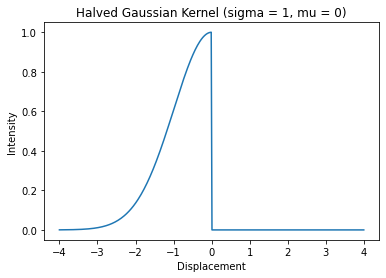

In [31]:
def halved_gaussian_kernel(x,sigma,mu):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sigma, 2.))) if x <= mu else 0

def count_path_score_gaussian(p, sigma, mu_shift = 0):
    diff = [p[i]-p[i+1] for i in range(len(p)-1)]
    _diff = [i if i != -np.inf else -1 for i in diff]
    score = np.sum([diff[i]*halved_gaussian_kernel(i,sigma,len(diff)-1 + mu_shift) for i in range(len(diff))])
    return score

#Plot the convolution kernel
x = np.linspace(-4,4,400)
y = [halved_gaussian_kernel(i,1,0) for i in x]
plt.plot(x,y)
plt.title('Halved Gaussian Kernel (sigma = 1, mu = 0)')
plt.xlabel('Displacement')
plt.ylabel('Intensity')

In [32]:
#Choosing the mean path length over all games as the sigma of our gaussian kernel
sigma = processed_paths_all['pathLength'].mean()/2

#Calculate path score for ended runs
processed_paths_all['score'] = processed_paths_all['M_path_dist_to_target'].apply(lambda d: count_path_score_gaussian(d,sigma, -1))

#Calculate path score for ongoing runs
dataset['score'] = dataset['path'].apply(lambda d: count_path_score_gaussian(d,sigma, 0))

</div>
<div class="1.1 explanation" style='background-color:#08135c; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:white">
       <h3>3.4 Analyse the validity of the scores</h3>
    </span>
</div>
</div>
<div class="1.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        We generate results from both ended runs and ongoing runs. 
        <h4>How we visualize the results?</h4>
        <ul><li>For ended runs, we plot the histogram and the difference of mean score for finished and unfinished (timeout or restart), then we plot how the mean values change with different path length.
        <li>For the ongoing runs, we only plot how the mean values change with different path length. We want to have a glance at the ability to differentiate the two at different playing steps.</ul>
            <h4>Conclusion</h4>
            Progress score is a feature to discriminate between a game that is going to fail or a game that is going to be successful. The prediction power increases with path length and seemingly reaches a plateau after path length 5. 
    </span>
</div>

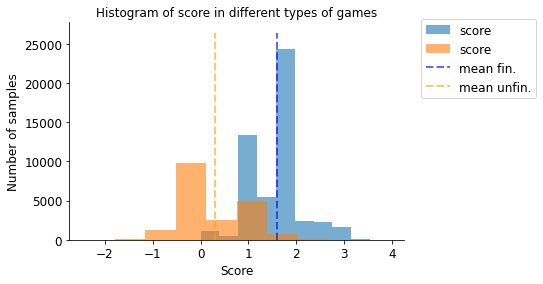

In [33]:
#For ended runs, we plot the histogram
scored_paths_all = processed_paths_all[processed_paths_all['score']!=-np.inf]

scored_paths_all[scored_paths_all['type'] == 'finished']['score'].hist(legend = True, grid=False, alpha=0.6)
scored_paths_all[scored_paths_all['type'] != 'finished']['score'].hist(legend = True, grid=False, alpha=0.6)

mean_finished = scored_paths_all.groupby('type')['score'].mean()[0]
mean_unfinished = scored_paths_all[scored_paths_all['type'] != 'finished']['score'].mean()

y_limit = 22000
plt.vlines(mean_finished, 0, y_limit*1.2, ls='--',alpha = 0.6, color='blue', linewidth=2, label = 'mean fin.')
plt.vlines(mean_unfinished, 0, y_limit*1.2, ls='--',alpha = 0.6, color='orange', linewidth=2, label = 'mean unfin.')

plt.legend(loc=(1.05, 0.65), prop={'size': 12})
plt.title('Histogram of score in different types of games', size=12)
plt.xlabel('Score', size=12)
plt.ylabel('Number of samples', size=12)


fig = plt.gcf()
ax = plt.gca()

#ax label formatting
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(12) 

#Remove spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

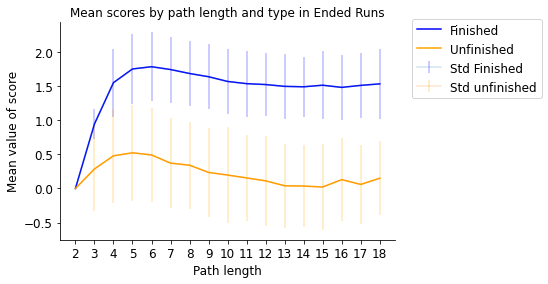

In [34]:
#We also discuss if the ablility to distinguish varies with path length.
scored_paths_all = processed_paths_all[processed_paths_all['score']!=-np.inf]
group = scored_paths_all.groupby('pathLength')
key_l=[]
mean_finished_l = []
mean_unfinished_l = []
#mean_restart_l = []
#mean_timeout_l = []
std_finished_l = []
#std_restart_l = []
#std_timeout_l = []
std_unfinished_l = []

for key, scored_paths in group:
    if key > 18:
        break
    
    key_l.append(key)
    # Create lists with the data for the line plot
    mean_finished_l.append(scored_paths.groupby('type')['score'].mean()[0])
    mean_unfinished_l.append(scored_paths[scored_paths['type'] != 'finished']['score'].mean())
    #mean_restart_l.append(scored_paths.groupby('type')['score'].mean()[1])
    #mean_timeout_l.append(scored_paths.groupby('type')['score'].mean()[2])
    
    # Create lists with the data for the std plot
    std_finished_l.append(scored_paths[scored_paths['type'] == 'finished']['score'].std())
    std_unfinished_l.append(scored_paths[scored_paths['type'] != 'finished']['score'].std())
    #std_restart_l.append(scored_paths[scored_paths['type'] == 'restart']['score'].std())
    #std_timeout_l.append(scored_paths[scored_paths['type'] == 'timeout']['score'].std())
    
plt.figure()
plt.errorbar(key_l,mean_finished_l, yerr=std_finished_l, ecolor='blue', elinewidth=2, alpha=0.2, label='Std Finished')
plt.errorbar(key_l,mean_unfinished_l, yerr=std_unfinished_l, ecolor='orange', elinewidth=2, alpha=0.2, label='Std unfinished')
#plt.errorbar(key_l,mean_restart_l, yerr=std_restart_l, ecolor='blue', elinewidth=2, alpha = 0.2, label='Std Restart')
#plt.errorbar(key_l,mean_timeout_l, yerr=std_timeout_l, ecolor='green', elinewidth=2, alpha = 0.2, label='Std Timeout')
plt.plot(key_l,mean_finished_l, color = 'blue', label= 'Finished')
plt.plot(key_l,mean_unfinished_l, color = 'orange', label= 'Unfinished')
#plt.plot(key_l,mean_restart_l, color = 'blue', label= 'Restart')
#plt.plot(key_l,mean_timeout_l, color = 'green', label= 'Timeout')
plt.legend(loc=(1.05, 0.65), prop={'size': 12})
ax = plt.gca()
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
plt.title('Mean scores by path length and type in Ended Runs', size=12)
plt.xlabel('Path length', size=12)
plt.ylabel('Mean value of score', size=12)

#ax label formatting
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(12) 

#Remove spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

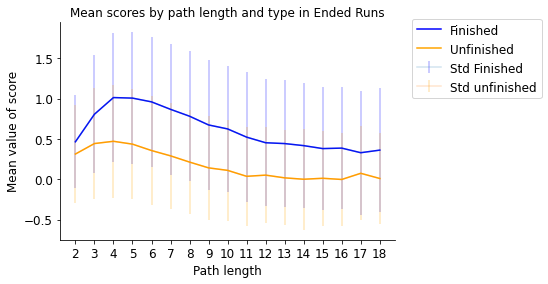

In [35]:
#Taking the score of every step in a game into consideration
scored_paths_all = dataset[dataset['score']!=-np.inf]

scored_paths_all = scored_paths_all[scored_paths_all['finished']==0]

group = scored_paths_all.groupby('pathLength')
key_l=[]
mean_finished_l = []
mean_unfinished_l = []
#mean_restart_l = []
#mean_timeout_l = []
std_finished_l = []
#std_restart_l = []
#std_timeout_l = []
std_unfinished_l = []

for key, scored_paths in group:
    if key > 18:
        break
    
    key_l.append(key)
    # Create lists with the data for the line plot
    mean_finished_l.append(scored_paths.groupby('type')['score'].mean()[0])
    mean_unfinished_l.append(scored_paths[scored_paths['type'] != 'finished']['score'].mean())
    #mean_restart_l.append(scored_paths.groupby('type')['score'].mean()[1])
    #mean_timeout_l.append(scored_paths.groupby('type')['score'].mean()[2])
    
    # Create lists with the data for the std plot
    std_finished_l.append(scored_paths[scored_paths['type'] == 'finished']['score'].std())
    std_unfinished_l.append(scored_paths[scored_paths['type'] != 'finished']['score'].std())
    #std_restart_l.append(scored_paths[scored_paths['type'] == 'restart']['score'].std())
    #std_timeout_l.append(scored_paths[scored_paths['type'] == 'timeout']['score'].std())
    
plt.figure()
plt.errorbar(key_l,mean_finished_l, yerr=std_finished_l, ecolor='blue', elinewidth=2, alpha=0.2, label='Std Finished')
plt.errorbar(key_l,mean_unfinished_l, yerr=std_unfinished_l, ecolor='orange', elinewidth=2, alpha=0.2, label='Std unfinished')
#plt.errorbar(key_l,mean_restart_l, yerr=std_restart_l, ecolor='blue', elinewidth=2, alpha = 0.2, label='Std Restart')
#plt.errorbar(key_l,mean_timeout_l, yerr=std_timeout_l, ecolor='green', elinewidth=2, alpha = 0.2, label='Std Timeout')
plt.plot(key_l,mean_finished_l, color = 'blue', label= 'Finished')
plt.plot(key_l,mean_unfinished_l, color = 'orange', label= 'Unfinished')
#plt.plot(key_l,mean_restart_l, color = 'blue', label= 'Restart')
#plt.plot(key_l,mean_timeout_l, color = 'green', label= 'Timeout')
plt.legend(loc=(1.05, 0.65), prop={'size': 12})
ax = plt.gca()
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
plt.title('Mean scores by path length and type in Ended Runs', size=12)
plt.xlabel('Path length', size=12)
plt.ylabel('Mean value of score', size=12)

#ax label formatting
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(12) 

#Remove spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

</div>
<div class="1.1 explanation" style='background-color:#08135c; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:white">
       <h3>4. Magical number of 5</h3>
    </span>
</div>
</div>
<div class="1.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        When analyzing the path length, we found a magical number which is exactly 5. People have the most chance to win the game with path length 5, and the most drive to continue playing even though they fail at path length greater than 5. Even the progress score reaches the climax at path length 5. This is our process to discover the magical number.<br>
        <h4>How we discovered this?</h4>
        <ul><li> Firstly, we analyse the path length and the chance to win the game at different path length. We found that games with path length 5 are more likely to be a winning game.
        <li> Secondly, we analysed at which step the players reached the minimun distance to the target. The path length is 5 or 4 for failed games, while it's 5 or 6 for successful games.
        <li> Thirdly, we analyse what will the users do when they ended a game. We also found that their motivation increases with path length and reaches plateau at path length 5.
        </ul>We believe this number has something to do with the structure of the graph network.
            <h4>What can we learn from this?</h4>
            <ul><li> First, we may consider it necessery to give hints when player theoretically can't finish a game at path length 5 or slightly greater than 5.
             <li> Second, we can be alerted if the distance drops too fast, because this may indicate a failed game.
             <li> Third, we try to add more difficulty to master players so that their path lengths are not too smaller than 5, in order to keep their motivation to continue playing.</ul>
    </span>
</div>

In [36]:
#The same function was used in our Homework 1, it's used for more credible plotting
def bootstrap_CI(data, nbr_draws, with_means = False, mean=True):
    means = np.zeros(nbr_draws)
    data = np.array(data)

    for n in range(nbr_draws):
        indices = np.random.randint(0, len(data), len(data))
        data_tmp = data[indices]
        
        if mean:
            means[n] = np.nanmean(data_tmp)
        else:
            means[n] = np.nansum(data_tmp) #.sum() mode if argument mean == False.
    if with_means :
        return [np.nanpercentile(means, 2.5),np.nanpercentile(means, 97.5)], means
    else : 
        return [np.nanpercentile(means, 2.5),np.nanpercentile(means, 97.5)]

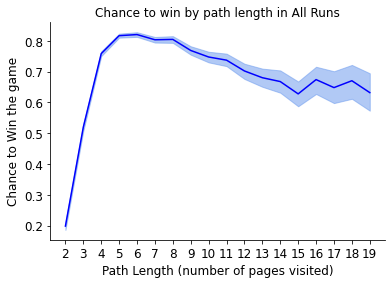

In [37]:
#Filter out the pathLength that has insufficient samples (less than 200)
dfd = processed_paths_all.groupby('pathLength').size()
path_length_list = list(dfd[dfd>200].index)

_paths_ = processed_paths_all[processed_paths_all['pathLength'].isin(path_length_list)].copy()

#Add an extra column for the sake of calculation
_paths_['is_successful'] = _paths_['type'].apply(lambda x: 1 if x == 'finished' else 0)

#Bootstrapping samples
df_plot = _paths_.groupby('pathLength').apply(lambda x: pd.concat(
    [pd.Series({
        'avg_is_continue': x['is_successful'].mean(),
        'lower_err_avg_is_continue': bootstrap_CI(x['is_successful'], 1000)[0],
        'upper_err_avg_is_continue': bootstrap_CI(x['is_successful'], 1000)[1]})]))

#Plot
plt.fill_between(df_plot.index,
                 df_plot['lower_err_avg_is_continue'] ,
                 df_plot['upper_err_avg_is_continue'], 
                 alpha = 0.5, color = 'cornflowerblue')
plt.plot(df_plot['avg_is_continue'], color = 'blue', label=path_length_list)

ax = plt.gca()
ax.xaxis.set_major_locator(plt.MultipleLocator(1))

plt.title('Chance to win by path length in All Runs', size=12)
plt.xlabel('Path Length (number of pages visited)', size=12)
plt.ylabel('Chance to Win the game', size=12)

fig = plt.gcf()
ax = plt.gca()

#ax label formatting
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(12) 

#Remove spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


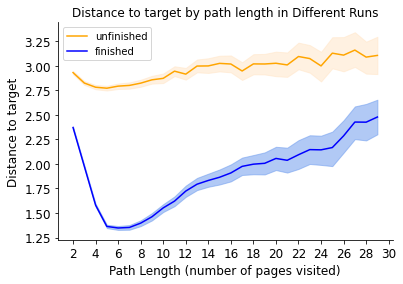

In [38]:
#What if people failed the run?
#Filter out the pathLength that has insufficient samples (less than 200)
dfd = dataset.groupby('pathLength').size()
path_length_list = list(dfd[dfd>200].index)

_paths_ = dataset[dataset['pathLength'].isin(path_length_list)].copy()

#Add an extra column for the sake of calculation
_paths_['dist_to_target'] = _paths_['path'].apply(lambda x: x[-1])
_paths_ = _paths_[_paths_['dist_to_target']!=np.inf]
_paths_u = _paths_[_paths_['type']!='finished']
_paths_f = _paths_[_paths_['type']=='finished']
#Bootstrapping samples
df_plot_u = _paths_u.groupby('pathLength').apply(lambda x: pd.concat(
    [pd.Series({
        'avg_dist_to_target': x['dist_to_target'].mean(),
        'lower_err_avg_dist_to_target': bootstrap_CI(x['dist_to_target'], 1000)[0],
        'upper_err_avg_dist_to_target': bootstrap_CI(x['dist_to_target'], 1000)[1]})]))

#Plot
plt.fill_between(df_plot_u.index,
                 df_plot_u['lower_err_avg_dist_to_target'] ,
                 df_plot_u['upper_err_avg_dist_to_target'], 
                 alpha = 0.5, color = 'bisque')
plt.plot(df_plot_u['avg_dist_to_target'], color = 'orange', label='unfinished')

#Bootstrapping samples
df_plot_f = _paths_f.groupby('pathLength').apply(lambda x: pd.concat(
    [pd.Series({
        'avg_dist_to_target': x['dist_to_target'].mean(),
        'lower_err_avg_dist_to_target': bootstrap_CI(x['dist_to_target'], 1000)[0],
        'upper_err_avg_dist_to_target': bootstrap_CI(x['dist_to_target'], 1000)[1]})]))

#Plot
plt.fill_between(df_plot_f.index,
                 df_plot_f['lower_err_avg_dist_to_target'] ,
                 df_plot_f['upper_err_avg_dist_to_target'], 
                 alpha = 0.5, color = 'cornflowerblue')
plt.plot(df_plot_f['avg_dist_to_target'], color = 'blue', label='finished')

ax = plt.gca()
ax.xaxis.set_major_locator(plt.MultipleLocator(2))

plt.legend()
plt.title('Distance to target by path length in Different Runs', size=12)
plt.xlabel('Path Length (number of pages visited)', size = 12)
plt.ylabel('Distance to target', size=12)

fig = plt.gcf()
ax = plt.gca()

#ax label formatting
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(12) 

#Remove spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

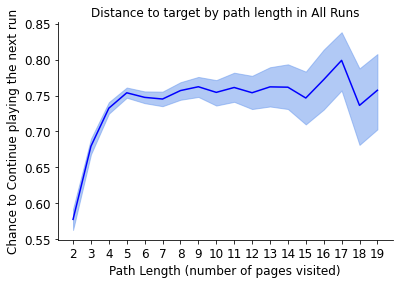

In [39]:
#Filter out the pathLength that has insufficient samples (less than 200)
dfd = processed_paths_all.groupby('pathLength').size()
path_length_list = list(dfd[dfd>200].index)

_paths_ = processed_paths_all[processed_paths_all['pathLength'].isin(path_length_list)].copy()

#Add an extra column for the sake of calculation
_paths_['is_continue'] = _paths_['bh_type'].apply(lambda x: 1 if x == 'continue' else 0)

#Bootstrapping samples
df_plot = _paths_.groupby('pathLength').apply(lambda x: pd.concat(
    [pd.Series({
        'avg_is_continue': x['is_continue'].mean(),
        'lower_err_avg_is_continue': bootstrap_CI(x['is_continue'], 1000)[0],
        'upper_err_avg_is_continue': bootstrap_CI(x['is_continue'], 1000)[1]})]))

#Plot
plt.fill_between(df_plot.index,
                 df_plot['lower_err_avg_is_continue'] ,
                 df_plot['upper_err_avg_is_continue'], 
                 alpha = 0.5, color = 'cornflowerblue')
plt.plot(df_plot['avg_is_continue'], color = 'blue', label=path_length_list)

ax = plt.gca()
ax.xaxis.set_major_locator(plt.MultipleLocator(1))

plt.title('Distance to target by path length in All Runs', size=12)
plt.xlabel('Path Length (number of pages visited)', size=12)
plt.ylabel('Chance to Continue playing the next run', size=12)

fig = plt.gcf()
ax = plt.gca()

#ax label formatting
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(12) 

#Remove spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

</div>
<div class="1.1 explanation" style='background-color:#08135c; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:white">
       <h3>5.1 Add features to the data</h3>
    </span>
</div>
</div>
<div class="1.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        We add the features to the data so that we can used the score computed for the starting and target page in our final logistic regression.
    </span>
</div>

In [40]:
# Get the categories corresponding to the article and aggregate them by a sum if multiple
categories['categories'] = categories.category.apply(lambda x : [x.split('.')[-1]])
categories_merged_2 = pd.DataFrame(categories.groupby('article').categories.agg(sum))

# Create the df with all the features
features = paths_all.sort_values(by='timestamp').groupby('hashedIpAddress').last()
features['starting'] = features.path.apply(lambda x : x.split(';')[0])
features['target'] = features['target'].apply(lambda t : get_score(t, 'frac_target', categories_merged_2, start_target_cats))
features['starting'] = features['starting'].apply(lambda t : get_score(t, 'frac_start', categories_merged_2, start_target_cats))
features = features[['starting', 'target']]
features.head(4)

,starting,target
hashedIpAddress,,
000386124f307de8,0.269728,0.616963
0007183207b6008f,0.469875,0.785974
000a09e202e88d10,0.533556,0.679462
000a5bac5b7781ea,0.423541,0.436056


In [41]:
#Standardize features
features = (features - features.mean())/features.std()

In [42]:
#Store in_game features in csv file
features.to_csv("data/in_game_features.csv", index = True, encoding='utf-8')